## segy gather import 

In [1]:
# Import common libraries
import sys
import segyio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

filename = "C:/Users/Jay.J.Chen/Documents/Projects/RL_Gather_Pick/cdpgathers_601-630.sgy"

# downloaded from https://wiki.seg.org/wiki/Stratton_3D_survey

In [2]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header


In [3]:
import re
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000  ##67332
    n_samples = f.samples.size
    twt = f.samples
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)  
    trace_headers = parse_trace_headers(f, n_traces)
    print(len(set(trace_headers['CDP']))) # number of CDPs
    print(set(trace_headers['CDP_TRACE']))  #number of traces for a gather

    trace_headers_fullgather = trace_headers[trace_headers['CDP_TRACE']==np.int32(24)] 
    cdps_with_full_gather = set(trace_headers_fullgather['CDP'].astype(np.int32))
    # print(cdps_with_full_gather) # list of CDP with full gather traces.
    # gather = np.asarray([np.copy(x) for x in f.iline[0:1, :]]) #works for inferable geometry segy file. 
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
# f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

5520
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


In [4]:
# trace_headers.set_index("TRACE_SEQUENCE_LINE", inplace=True)
# trace_headers.head(100)
# trace_headers.loc[[100],['CDP','CDP_TRACE']]
#data.shape
# type(np.int32(3))
# type(3)
# cdps_with_full_gather = set(trace_headers_fullgather['CDP'].astype(np.int32))
# trace_headers.iloc[np.int32(99),4:6]
#cdps_with_full_gather

In [5]:
# select a gather for fixed cdp=7891  from full gather list
trace_idx_start = 0
trace_idx_end = 0
for trace_idx in range(23290,23340): 
    trace = data[trace_idx,:].T
    # trace_headers.set_index("TRACE_SEQUENCE_LINE", inplace=True) #do this only once.
    # trace_header = trace_headers.loc[[np.int32(trace_idx)],['CDP','CDP_TRACE']]
    trace_header_cdp = trace_headers.iloc[np.int32(trace_idx),5]
    trace_header_cdp_trace = trace_headers.iloc[np.int32(trace_idx),6]
    if trace_header_cdp == 7891 and trace_header_cdp_trace==1:
        trace_idx_start = trace_idx
    elif trace_header_cdp == 7891 and trace_header_cdp_trace==24:
        trace_idx_end = trace_idx       
data_full_gather = data[trace_idx_start:trace_idx_end,:].T

In [6]:
# data_full_gather_non_zero_label = np.where(~data_full_gather.any(axis=1))[0]
# print(data_full_gather_non_zero)

data_full_gather_non_zero = data_full_gather[499:1649,:]

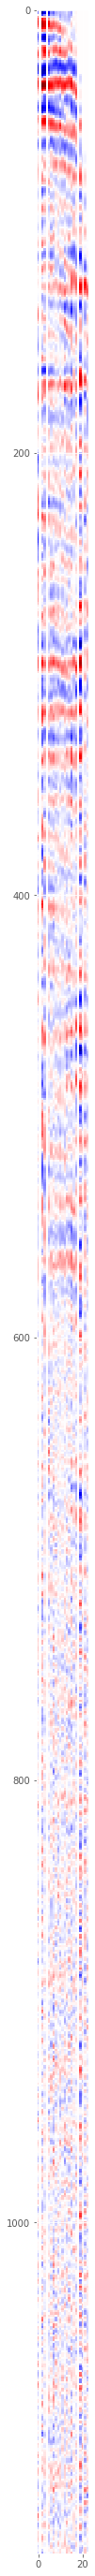

In [7]:
# Figure
clip = 1e+3
vmin, vmax = -clip, clip
figsize=(25, 50)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                       squeeze=False,
                       sharex=True)
axs = axs.ravel()
# im = axs[0].imshow(data[0:100,:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
im = axs[0].imshow(data_full_gather_non_zero, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
fig.savefig('C:/Users/Jay.J.Chen/Documents/Projects/RL_Gather_Pick/a.png')